In [1]:
import matplotlib as mpl
mpl.use("pgf")
pgf_with_pdflatex = {
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)
import matplotlib.pyplot as plt

%pylab inline
import numpy as np
import pylab as pb
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from sklearn import preprocessing
pb.ion()

sns.set_context("paper")


/Users/ggutierrez/anaconda/lib/python3.5/site-packages/matplotlib/backends/backend_pgf.py:54: UserWarning: error getting fonts from fc-list
  warnings.warn('error getting fonts from fc-list', UserWarning)


Populating the interactive namespace from numpy and matplotlib


In [ ]:
def bmatrix(a,fname):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :fname: file to write to
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    with open(fname, "w") as out_file:
        lines = str(a).replace('[', '').replace(']', '').splitlines()
        rv = [r'\begin{bmatrix}']
        rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
        rv +=  [r'\end{bmatrix}']
        out_file.write('\n'.join(rv))

In [2]:
# first 4 columns are input: Wing-length, Wing-width, Tail-length, Arm-length
# last 2 columns are outputs in seconds (flight time for two trials)
data = np.genfromtxt('lab1_data.csv',delimiter=',')

# Data used for the plotting library
data2 = pd.read_csv('lab1_data.csv', names=["Wing-length", "Wing-width", "Tail-length", "Arm-length", "t1", "t2"])

X = data[:,0:4]
F = np.mean(data[:,4:6],axis=1)[:,None]

# Linear regression

## Q1 Plotting the data

In [ ]:
# To plot just the upper diagonal and the histogram
# g = sns.PairGrid(data2)
# g.map_upper(plt.scatter)
# g.map_diag(plt.hist)

sns.pairplot(data2)

After looking at data we can conclude:
- There is not much noise between the realizations of every experiment.

In [ ]:
sns.pairplot(data2, x_vars=['t1'], y_vars=['t2'])
plt.xlabel('Falling time realization 1')
plt.ylabel('Falling time realization 2')
plt.savefig('t1_vs_t2.pgf')

In [ ]:
np.mean(np.var(data[:,4:6],axis=1))

- There is a linear correlation between the wing length and the falling time.

In [ ]:
pg = sns.pairplot(data2, x_vars=['t1', 't2'], y_vars=['Wing-length'])
pg.axes[0,0].set_xlabel('Falling time realization 1')
pg.axes[0,1].set_xlabel('Falling time realization 2')
pg.axes[0,0].set_ylabel('Wing length')
plt.savefig('wing_length_vs_times.pgf')

- There is a linear correlation between the arm length and the falling time.

In [ ]:
pg = sns.pairplot(data2, x_vars=['t1', 't2'], y_vars=['Arm-length'])
pg.axes[0,0].set_xlabel('Falling time realization 1')
pg.axes[0,1].set_xlabel('Falling time realization 2')
pg.axes[0,0].set_ylabel('Arm length')
plt.savefig('arm_length_vs_times.pgf')

- It seems to be a small linear correlation between the arm length and the tail length.

In [ ]:
pg = sns.pairplot(data2, x_vars=['Tail-length'], y_vars=['Arm-length'])
pg.axes[0,0].set_xlabel('Tail length')
pg.axes[0,0].set_ylabel('Arm length')
plt.savefig('tail_length_vs_arm_length.pgf')

## Q2 Completing the linear regression

Computes a linear regression for $X$ and $F$ as:

\begin{align*}
m(X) =& B(X)\hat{\beta} \\
m(X) =& B(X)(B(X)^t B(X))^{-1}B(X)^t F
\end{align*}

Returns the vector of coefficients $\hat{\beta}$ and the covariance matrix $covBeta$:

\begin{align*}
\hat{\beta} =& (B(X)^t B(X))^{-1}B(X)^t F \\
covBeta =& (B(X)^t B(X))^{-1}B(X)^t cov[\epsilon,\epsilon^t]B(X)(B(X)^t B(X))^{-1}
\end{align*}



In [3]:
def LR(X,F,B,tau2):
    #input:	  X, np.array with d columns representing the DoE
    #		  F, np.array with 1 column representing the observations
    #		  B, a function returning the (p) basis functions evaluated at x
    # 		  tau2, noise variance
    #output:  beta, estimate of coefficients np.array of shape (p,1)
    #		  covBeta, cov matrix of beta, np.array of shape (p,p)

    # ... to be completed ...
    BX = B(X)
    A = np.linalg.inv(np.dot(BX.T, BX))
    C = np.dot(A, BX.T)
    D = np.dot(BX, A)
    beta = np.dot(C, F)
    covBeta = np.dot(C,D)*tau2
    return(beta,covBeta)

## Q3 Prediction

In [133]:
def predLR(x,B,beta,covBeta):
    #function returning predicted mean and variance
    #input:	  x, np.array with d columns representing m prediction points
    #		  B, a function returning the (p) basis functions evaluated at x
    #		  beta, estimate of the regression coefficients
    # 		  covBeta, covariance matrix of beta
    #output:  m, predicted mean at x, np.array of shape (m,1)
    #		  v, predicted variance matrix, np.array of shape (m,m)

    BB = B(x)
    m = np.dot(BB, beta)
    v = np.dot(BB,covBeta)
    v = np.dot(v,BB.T)
    return(np.asarray(m),np.asarray(v))

def plotModel(x,m,v, ax=pb, xreal=None, freal=None):
	#input:	  x, np.array with d columns representing m prediction points
	#		  m, predicted mean at x, np.array of shape (m,1)
	#		  v, predicted variance matrix, np.array of shape (m,m)
    x = x.flatten()
    m = m.flatten()
    v = np.diag(v)
    #print x.shape, m.shape
    upper=m+2*np.sqrt(v)
    lower=m-2*np.sqrt(v)
    ax.plot(x,m,color="#204a87",linewidth=2)
    ax.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color="#729fcf",alpha=0.3)
    ax.plot(x,upper,color="#204a87",linewidth=0.2)
    ax.plot(x,lower,color="#204a87",linewidth=0.2)
    if xreal is not None and freal is not None:
        xreal = xreal.flatten()
        freal = freal.flatten()
        ax.plot(xreal,freal,'*')
        ax.set_xlim(np.min(x)-0.2,np.max(x)+0.2)
        #ax.set_ylim(np.min(freal)-0.2,np.max(freal)+0.2)

def R2(X,F,B,beta):
    return(1-sum((F-np.dot(B(X),beta))**2)/sum((F-np.mean(F))**2))

def testData(x,n=100):
    ret = []
    for i in range(x.shape[1]):
        a = np.linspace(np.min(x[:,i]), np.max(X[:,i]), n)
        ret.append(a)
    return np.array(ret).T 

### First attempt

Model prediction using a a constant effect, a linear effect on wing length and a quadratic effect on wing length.

In [ ]:
def B(x):
    # function returning the matrix of basis functions evaluated at x
    #input:	  x, np.array with d columns
    #output:  a matrix of geberal term B_{i,j} = b_j(x_i)
    b0 = np.ones((x.shape[0],1)) # Constant effect
    b1 = (x[:,0])[:,None]        # Linear effect (wing length)
    b2 = np.power(b1, 2)         # Cuadratic effect (wing length)
    #b2 = x[:,0:1]*x[:,3:4]
    B = np.hstack((b0,b1,b2))
    return B

tau2 = np.var(data[:,4] - data[:,5])/2.0
beta, covBeta = LR(X, F, B, tau2)

# Use the LR to predict
x = testData(X)
mean_pred, cov_pred = predLR(x, B, beta, covBeta)

# Plot results
f, ((ax_wl, ax_ww), (ax_tl, ax_al)) = plt.subplots(2,2, figsize=(6,3), sharey=True)
plotModel(x[:,0], mean_pred, cov_pred, ax=ax_wl, xreal=X[:,0],freal=F)
plotModel(x[:,1], mean_pred, cov_pred, ax=ax_ww, xreal=X[:,1],freal=F)
plotModel(x[:,2], mean_pred, cov_pred, ax=ax_tl, xreal=X[:,2],freal=F)
plotModel(x[:,3], mean_pred, cov_pred, ax=ax_al, xreal=X[:,3],freal=F)
#ax_wl.set_xlim(np.min(x[:,0])-0.2, np.max(x[:,0])
#, ax_ww, ax_tl, ax_al

ax_wl.set_ylabel("Flying time")
ax_tl.set_ylabel("Flying time")
ax_wl.set_xlabel("Wing length")
ax_ww.set_xlabel("Wing width")
ax_tl.set_xlabel("Tail length")
ax_al.set_xlabel("Arm length")
plt.tight_layout()
f.subplots_adjust(hspace=0.5)
plt.savefig('reg_badr2.pgf')

print ("R2: %f" % R2(X,F,B,beta))

### Second attempt 

Model prediction using other basis functions

0.77856980788198116

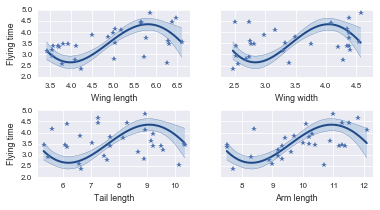

In [16]:
def B2(x):
    # function returning the matrix of basis functions evaluated at x
    #input:	  x, np.array with d columns
    #output:  a matrix of geberal term B_{i,j} = b_j(x_i)
    b0 = np.ones((x.shape[0],1)) # Constant effect
    
    b1 = x
    # The above basis is equivalent to:
    #b10 = x[:,0:1] # This is extremly important in R2
    #b11 = x[:,1:2]
    #b12 = x[:,2:3]
    #b13 = x[:,3:4]
    
    b2 = x[:,3:4]**2.0
    b3 = np.sin(x[:,3:4])
    b4 = np.cos(x[:,0:1])
    B = np.hstack((b0, b1, b2, b3, b4))
    #B = np.hstack((b0, b10, b11, b12, b13, b2, b3, b4))
    return B

# Compute a linear regression with the experiment data
tau2 = np.var(data[:,4] - data[:,5])/2.0
(beta,covBeta) = LR(X,F,B2,tau2)

# bmatrix(covBeta,'covBetaR2.tex')
# bmatrix(beta, 'betaR2.tex')

# Use the LR to predict
x = testData(X)
mean_pred, cov_pred = predLR(x, B2, beta, covBeta)

# Plot results
f, ((ax_wl, ax_ww), (ax_tl, ax_al)) = plt.subplots(2,2, figsize=(6,3), sharey=True)
plotModel(x[:,0], mean_pred, cov_pred, ax=ax_wl, xreal=X[:,0],freal=F)
plotModel(x[:,1], mean_pred, cov_pred, ax=ax_ww, xreal=X[:,1],freal=F)
plotModel(x[:,2], mean_pred, cov_pred, ax=ax_tl, xreal=X[:,2],freal=F)
plotModel(x[:,3], mean_pred, cov_pred, ax=ax_al, xreal=X[:,3],freal=F)
ax_wl.set_ylabel("Flying time")
ax_tl.set_ylabel("Flying time")
ax_wl.set_xlabel("Wing length")
ax_ww.set_xlabel("Wing width")
ax_tl.set_xlabel("Tail length")
ax_al.set_xlabel("Arm length")
f.subplots_adjust(hspace=0.5)
plt.savefig('reg_beterr2.pgf')
R2(X,F,B2,beta)

### Third attempt (scaled model)

Model prediction on scaled data and with the same basis functions as above.

In [ ]:
# Compute the linear regression on scaled data
scaler = preprocessing.MinMaxScaler(feature_range=(0.0,1.0))
Xscaled = scaler.fit_transform(data[:,0:4])
Yscaled = scaler.fit_transform(data[:,4:6])

Fscaled = np.mean(Yscaled,axis=1)[:,None]
tau2scaled = np.var(Yscaled[:,0] - Yscaled[:,1])/2.0
(betaScaled,covBetaScaled) = LR(Xscaled,Fscaled,B2,tau2scaled)

# Predict for random generated data
x = testData(Xscaled)
mean_pred, cov_pred = predLR(x, B2, betaScaled, covBetaScaled)

# Plot results
f, ((ax_wl, ax_ww), (ax_tl, ax_al)) = plt.subplots(2,2, figsize=(7,4), sharey=True)
plotModel(x[:,0], mean_pred, cov_pred, ax=ax_wl, xreal=Xscaled[:,0],freal=Fscaled)
plotModel(x[:,1], mean_pred, cov_pred, ax=ax_ww, xreal=Xscaled[:,1],freal=Fscaled)
plotModel(x[:,2], mean_pred, cov_pred, ax=ax_tl, xreal=Xscaled[:,2],freal=Fscaled)
plotModel(x[:,3], mean_pred, cov_pred, ax=ax_al, xreal=Xscaled[:,3],freal=Fscaled)
ax_wl.set_ylabel("Flying time")
ax_tl.set_ylabel("Flying time")
ax_wl.set_xlabel("Wing length")
ax_ww.set_xlabel("Wing width")
ax_tl.set_xlabel("Tail length")
ax_al.set_xlabel("Arm length")
f.subplots_adjust(hspace=0.5)
R2(Xscaled,Fscaled,B2,betaScaled)

## Q4 P-Values

In [17]:
def pvalue(beta,covBeta,X):
	df = X.shape[0] - len(beta)
	cdf = stats.t.cdf(np.abs(beta)/np.sqrt(np.diag(covBeta)),df)
	return(2*(1 - cdf))

np.round(pvalue(beta,covBeta,X),2)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.8 ,  0.  ,  0.  ,  0.  ,  0.15,  0.  ,  0.  ,  0.01],
       [ 0.94,  0.27,  0.  ,  0.  ,  0.68,  0.  ,  0.15,  0.4 ],
       [ 0.96,  0.45,  0.  ,  0.  ,  0.78,  0.  ,  0.33,  0.57],
       [ 0.65,  0.  ,  0.  ,  0.  ,  0.02,  0.  ,  0.  ,  0.  ],
       [ 0.98,  0.71,  0.1 ,  0.06,  0.89,  0.01,  0.62,  0.78],
       [ 0.89,  0.04,  0.  ,  0.  ,  0.43,  0.  ,  0.01,  0.11],
       [ 0.71,  0.  ,  0.  ,  0.  ,  0.05,  0.  ,  0.  ,  0.  ]])

## Q5 Other physical quantities

In [117]:
## coordinate change
def angle(X):
	# X is Wing-length, Wing-width, Tail-length, Arm-length
	# returns the angle (in degrees) between the tail and the wing
    wl = X[:,0]
    ww = X[:,1]
    tl = X[:,2]
    al = X[:,3]
    #return(np.pi/180*np.arccos(-1.*((X[:,3]-2.5)**2-(X[:,2]-2.5)**2-X[:,0]**2)/(2*(X[:,2]-2.5)*X[:,0])))
    return(np.pi/180*np.arccos(-1.*((al-2.5)**2-(tl-2.5)**2-wl**2)/(2*(tl-2.5)*wl)))

def wingarea(X):
	# X is Wing-length, Wing-width, Tail-length, Arm-length
	# returns wing area (in squared centimiters)
    wl = X[:,0]
    ww = X[:,1]
    return(wl*ww)

def wingspan(X):
	# X is Wing-length, Wing-width, Tail-length, Arm-length
	# returns the wingspan 
    wl = X[:,0]
    ww = X[:,1]
    # Wing span:
    ws = 2.0 * np.sqrt(ww**2 + wl**2)
    return ws

def wingspan_tail_length_ratio(X):
    # X is Wing-length, Wing-width, Tail-length, Arm-length
	# returns the wingspan / tail-length ratio
    tl = X[:,2]
    ws = wingspan(X)
    return ws / tl

def armLength(X):
	# X is Wing-length, Wing-width, Tail-length, angle (in degrees) between the tail and the wing
	# returns the arm length
	return(np.sqrt(X[:,0]**2+(X[:,2]-2.5)**2-2*np.cos(X[:,3]*180/np.pi)*X[:,0]*(X[:,2]-2.5))+2.5)

def transform(X):
    # Transforms X to include other phisical quantities. 
    # Columns: angle, wing area, wing span and wing span to tail ratio
    a = angle(X)[:,None]
    wa = wingarea(X)[:,None]
    ws = wingspan(X)[:,None]
    return np.hstack((a, wa, ws))

In [118]:
TX = transform(X)

newdim = np.hstack((TX,F))
dataNewDim = pd.DataFrame(data=newdim, columns=["Angle", "Wing area", "Wing span", "Falling time"])

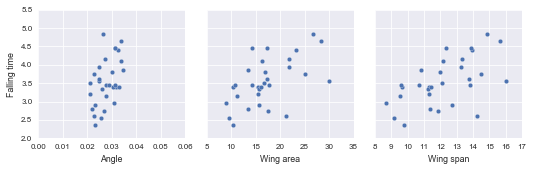

In [119]:
sns.pairplot(dataNewDim,y_vars=["Falling time"], x_vars=["Angle", "Wing area", "Wing span"])

0.6203790023833694

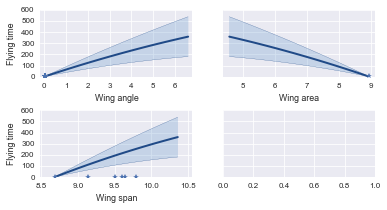

In [146]:
def B3(x):
    # function returning the matrix of basis functions evaluated at x
    #input:	  x, np.array with d columns
    #output:  a matrix of geberal term B_{i,j} = b_j(x_i)
    b0 = np.ones((x.shape[0],1)) # Constant effect
    b1 = x[:,0:1]
    b3 = x[:,0:1] * x[:,1:2]
    b4 = np.cos(x[:,2:3])
    B = np.hstack((b0, b1, b3, b4))
    return B

# Compute a linear regression with the experiment data
tau2 = np.var(data[:,4] - data[:,5])/2.0
(beta,covBeta) = LR(TX,F,B3,tau2)

# bmatrix(covBeta,'covBetaR2.tex')
# bmatrix(beta, 'betaR2.tex')

# Use the LR to predict
x = testData(TX)
mean_pred, cov_pred = predLR(x, B3, beta, covBeta)

# Plot results
f, ((ax_wang, ax_warea), (ax_ws, ax_wsr)) = plt.subplots(2,2, figsize=(6,3), sharey=True)
plotModel(x[:,0], mean_pred, cov_pred, ax=ax_wang, xreal=TX[:,0],freal=F)
plotModel(x[:,1], mean_pred, cov_pred, ax=ax_warea, xreal=TX[:,1],freal=F)
plotModel(x[:,2], mean_pred, cov_pred, ax=ax_ws, xreal=TX[:,2],freal=F)
ax_wang.set_ylabel("Flying time")
ax_ws.set_ylabel("Flying time")
ax_wang.set_xlabel("Wing angle")
ax_warea.set_xlabel("Wing area")
ax_ws.set_xlabel("Wing span")
f.subplots_adjust(hspace=0.5)
plt.savefig('reg_physdim.pgf')
R2(TX,F,B3,beta)

# Gaussian process regression

## Kernel classification

- Constant kernel: $k(x,y) = \sigma^2$

In [ ]:
def kern(X,Y,sigma2=1.):
	k = sigma2*np.ones((X.shape[0],Y.shape[0]))
	return(k)

- Gaussian kernel

In [ ]:
def kern(X,Y,sigma2=1.,theta=.2):
	d2 = np.sum((X[:,None,:]-Y[None,:,:])**2/theta**2,2)
	k = sigma2*np.exp(-d2/2.)
	return(k)

- Matern 3/2

In [148]:
def kern(X,Y,sigma2=1.,theta=.2):
	d = np.sqrt(np.sum((X[:,None,:]-Y[None,:,:])**2/theta**2,2))
	k = sigma2*(1+np.sqrt(3)*d)*np.exp(-np.sqrt(3)*d)
	return(k)

- Unclassified

In [149]:
def kern(X,Y,sigma2=1.):
	k = sigma2*np.fmin(X,Y.T)
	return(k)

- Unclassified

In [150]:
def kern(X,Y,sigma2=1.):
	k = sigma2*np.all(X[:,None,:]==Y[None,:,:],axis=2)
	return(k)

## SampleGP